In [1]:
from confluent_kafka import Consumer, TopicPartition, KafkaException, KafkaError
import pandas as pd
import json

# Kafka Consumer Configuration
consumer = Consumer({
    'bootstrap.servers': 'localhost:9092',  # Kafka broker address
    'group.id': 'eda-group',               # Consumer group
    'auto.offset.reset': 'earliest',       # Start from the beginning
    'enable.auto.commit': False            # Do not commit offsets automatically
})

# Subscribe to the topic
topic = 'model-topic'
consumer.subscribe([topic])

In [2]:
from cassandra.cluster import Cluster

In [3]:
# Connect to Cassandra
def connect_to_cassandra():
    cluster = Cluster(['127.0.0.1'])  
    session = cluster.connect()
    session.set_keyspace('offset_keyspace')  
    return session

# Read the value from the table
def read_offset(session, offset_name):
    query = "SELECT value FROM offset_table WHERE offset = %s"
    result = session.execute(query, (offset_name,))
    for row in result:
        print(f"Current value for offset '{offset_name}': {row.value}")
        return row.value
    print(f"No record found for offset '{offset_name}'")
    return None

In [4]:
def update_offset(session, offset_name, new_value):
    """
    Updates the value of the given offset in the Cassandra table.
    :param session: The Cassandra session object.
    :param offset_name: The name of the offset to update.
    :param new_value: The new value to set for the offset.
    """
    try:
        query = "UPDATE offset_table SET value = %s WHERE offset = %s"
        session.execute(query, (new_value, offset_name))
        print(f"Updated offset '{offset_name}' to new value: {new_value}")
    except Exception as e:
        print(f"Error updating Cassandra: {e}")

In [5]:
session = connect_to_cassandra()

if session:
    # Define the offset name you want to read
    offset_name = 'current_offset'
    # Read the current offset value
    current_value = read_offset(session, offset_name)
    # Perform additional logic with the retrieved value if necessary
    if current_value is not None:
        print(f"The current offset value is: {current_value}")
    else:
        print("No value retrieved. Make sure the record exists in the table.")

Current value for offset 'current_offset': 29685
The current offset value is: 29685


In [6]:
# Retrieve metadata to get the end offsets
def get_end_offsets(consumer, topic):
    metadata = consumer.list_topics(topic)
    partitions = metadata.topics[topic].partitions.keys()  # Get all partition IDs
    end_offsets = {}
    for partition in partitions:
        tp = TopicPartition(topic, partition)
        low, high = consumer.get_watermark_offsets(tp, timeout=5.0)
        if high >= 0:  # Ensure valid offsets
            end_offsets[tp] = high
        else:
            print(f"Warning: Partition {partition} has no valid end offset.")
    return end_offsets

In [7]:
print("Fetching end offsets for the topic...")
end_offsets = get_end_offsets(consumer, topic)
print("End offsets:", end_offsets)

Fetching end offsets for the topic...
End offsets: {TopicPartition{topic=model-topic,partition=0,offset=-1001,leader_epoch=None,error=None}: 16322, TopicPartition{topic=model-topic,partition=1,offset=-1001,leader_epoch=None,error=None}: 9741, TopicPartition{topic=model-topic,partition=2,offset=-1001,leader_epoch=None,error=None}: 9805}


In [8]:
# Consume messages up to the current end offsets
messages = []
try:
    while True:
        msg = consumer.poll(1.0)  # Poll for messages
        if msg is None:
            continue
        if msg.error():
            if msg.error().code() == KafkaError._PARTITION_EOF:
                print(f"Reached end of partition {msg.partition()}")
                continue
            else:
                raise KafkaException(msg.error())

        # Decode and store the message
        message_value = json.loads(msg.value().decode('utf-8'))
        messages.append(message_value)

        # Check if we've consumed up to the end offset
        tp = TopicPartition(msg.topic(), msg.partition())
        if tp in end_offsets and msg.offset() + 1 >= end_offsets[tp]:
            print(f"Finished consuming partition {msg.partition()}")
            del end_offsets[tp]
            if not end_offsets:
                break  # Stop if all partitions are consumed

finally:
    consumer.close()

Finished consuming partition 2
Finished consuming partition 1
Finished consuming partition 0


In [9]:
# Convert messages to a Pandas DataFrame
df = pd.DataFrame(messages)

In [10]:
update_offset(session, offset_name, len(messages))

Updated offset 'current_offset' to new value: 35868


In [11]:
df.shape

(35868, 13)

In [ ]:
# Display the schema
print("\nSchema:")
print(df.dtypes)

# Show the first few rows
print("\nFirst few rows of the DataFrame:")
print(df.head())

# Perform basic statistics
print("\nBasic Statistics:")
print(df.describe(include='all'))


In [13]:
df.shape

(35868, 13)

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [15]:
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
df['5s_interval'] = df['timestamp'].dt.floor('5s')
df_ylife = df[df['source'] == 'YLIFE_FEED']
df_xtb = df[df['source'] == 'XTB_FEED']

### YLIFE

In [16]:
df_ylife = df_ylife.drop(columns = ['bid', 'ask', 'spread_raw', 'spread_table', 'data_type', 'source'])
df_ylife = df_ylife.drop(columns = 'timestamp')

In [17]:
# Group by 5-second intervals and symbol, and calculate the mean for numerical columns
grouped_df_ylife = (
    df_ylife.groupby(['5s_interval', 'symbol'])
    .mean()
    .reset_index()
)

In [18]:
grouped_df_ylife

,5s_interval,symbol,price,volume,volatility,market_sentiment,trading_activity
0,2025-01-05 12:50:05,COP,100.730000,3.322062e+06,1.468000,0.178000,33.530000
1,2025-01-05 12:50:05,XOM,107.783333,1.334578e+07,0.378667,-0.075667,61.013333
2,2025-01-05 12:50:10,COP,100.643333,3.335795e+06,1.488333,0.139000,31.020000
3,2025-01-05 12:50:10,SHEL,64.520000,5.021484e+06,0.398667,-0.278333,62.336667
4,2025-01-05 12:50:10,XOM,108.610000,1.318917e+07,0.390000,-0.078000,59.450000
...,...,...,...,...,...,...,...
17778,2025-01-05 21:14:45,SHEL,65.240000,7.247188e+06,1.511000,0.701000,6.140000
17779,2025-01-05 21:14:50,BP,30.485000,4.532414e+06,0.432000,-0.493500,55.985000
17780,2025-01-05 21:14:50,COP,98.150000,3.012491e+06,1.488000,-0.870000,18.490000
17781,2025-01-05 21:14:50,SHEL,64.940000,7.389907e+06,1.489000,0.683000,3.130000


In [19]:
# Generate a complete range of 5-second intervals
full_intervals = pd.date_range(
    start=df['5s_interval'].min(),
    end=df['5s_interval'].max(),
    freq='5S'
)

# Create a complete DataFrame with all tickers and intervals
complete_df_ylife = pd.MultiIndex.from_product(
    [full_intervals, df['symbol'].unique()],
    names=['5s_interval', 'symbol']
).to_frame(index=False)


# Merge with grouped data to find missing intervals
merged_df = complete_df_ylife.merge(grouped_df_ylife, on=['5s_interval', 'symbol'], how='left')

# Interpolate missing values for numerical columns
interpolated_df_ylife = merged_df.copy()
interpolated_df_ylife = interpolated_df_ylife.groupby('symbol').apply(lambda group: group.interpolate())
interpolated_df_ylife

/tmp/ipykernel_170121/347688852.py:2: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  full_intervals = pd.date_range(
/tmp/ipykernel_170121/347688852.py:20: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  interpolated_df_ylife = interpolated_df_ylife.groupby('symbol').apply(lambda group: group.interpolate())
/tmp/ipykernel_170121/347688852.py:20: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  interpolated_df_ylife = interpolated_df_ylife.groupby('symbol').apply(lambda group: group.interpolate())
/tmp/ipykernel_170121/347688852.py:20: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolatin

5s_interval symbol    price        volume  volatility  \
symbol                                                                       
BP     3     2025-01-05 12:50:00     BP      NaN           NaN         NaN   
       8     2025-01-05 12:50:05     BP      NaN           NaN         NaN   
       13    2025-01-05 12:50:10     BP      NaN           NaN         NaN   
       18    2025-01-05 12:50:15     BP   30.540  6.456771e+06    0.694000   
       23    2025-01-05 12:50:20     BP   30.515  6.254577e+06    0.681000   
...                          ...    ...      ...           ...         ...   
XOM    30272 2025-01-05 21:14:30    XOM  105.250  1.453143e+07    0.695333   
       30277 2025-01-05 21:14:35    XOM  105.305  1.452178e+07    0.697500   
       30282 2025-01-05 21:14:40    XOM  105.360  1.451213e+07    0.699667   
       30287 2025-01-05 21:14:45    XOM  105.415  1.450248e+07    0.701833   
       30292 2025-01-05 21:14:50    XOM  105.470  1.449284e+07    0.704000   

              market_sentiment  trading_activity  
symbol                                            
BP     3                   NaN               NaN  
       8                   NaN               NaN  
       13                  NaN               NaN  
       18               0.4240            39.520  
       23               0.3195            40.455  
...                        ...               ...  
XOM    30272           -0.6310            48.880  
       30277           -0.6280            49.375  
       30282           -0.6250            49.870  
       30287           -0.6220            50.365  
       30292           -0.6190            50.860  

[30295 rows x 7 columns]

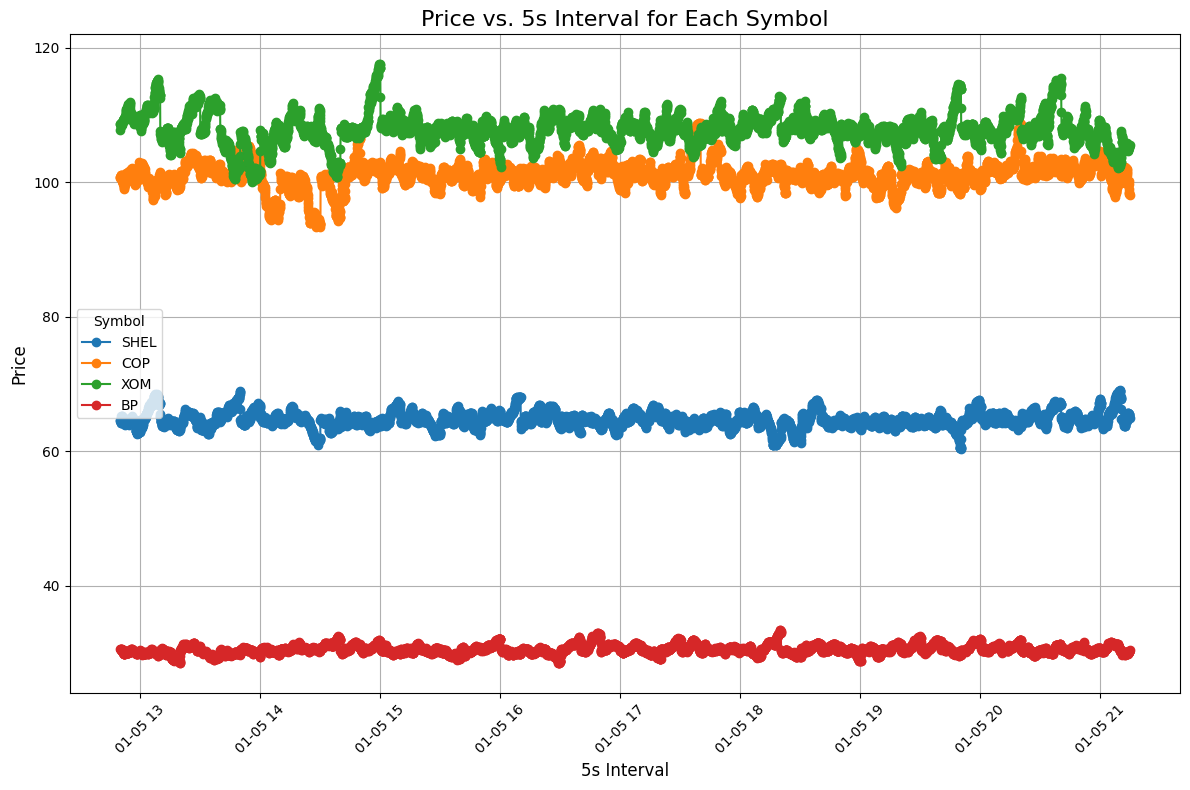

In [20]:
plt.figure(figsize=(12, 8))

# Plot for each symbol
for symbol in df_ylife['symbol'].unique():
    symbol_data = interpolated_df_ylife[interpolated_df_ylife['symbol'] == symbol]
    plt.plot(
        symbol_data['5s_interval'], 
        symbol_data['price'], 
        label=symbol, 
        marker='o', 
        linestyle='-'
    )

plt.title("Price vs. 5s Interval for Each Symbol", fontsize=16)
plt.xlabel("5s Interval", fontsize=12)
plt.ylabel("Price", fontsize=12)
plt.legend(title="Symbol")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

### XTB

In [21]:
df_xtb = df_xtb.drop(columns = ['price', 'volume', 'volatility', 'market_sentiment','trading_activity', 'data_type', 'source', 'timestamp'])
df_xtb

,symbol,bid,ask,spread_raw,spread_table,5s_interval
6034,ETHEREUM,3614.70,3627.20,12.50,12.50,2025-01-05 12:50:00
6039,ETHEREUM,3614.05,3626.55,12.50,12.50,2025-01-05 12:50:05
6041,ETHEREUM,3613.90,3626.80,12.90,12.90,2025-01-05 12:50:10
6044,ETHEREUM,3613.90,3626.80,12.90,12.90,2025-01-05 12:50:10
6045,ETHEREUM,3613.80,3626.30,12.50,12.50,2025-01-05 12:50:20
...,...,...,...,...,...,...
35858,ETHEREUM,3633.64,3647.19,13.55,13.55,2025-01-05 21:14:25
35859,ETHEREUM,3633.64,3647.34,13.70,13.70,2025-01-05 21:14:30
35863,ETHEREUM,3634.19,3647.74,13.55,13.55,2025-01-05 21:14:35
35864,ETHEREUM,3634.05,3647.61,13.56,13.56,2025-01-05 21:14:45


In [22]:
# Group by 5-second intervals and symbol, and calculate the mean for numerical columns
grouped_df_xtb = (
    df_xtb.groupby(['5s_interval', 'symbol'])
    .mean()
    .reset_index()
)
grouped_df_xtb

,5s_interval,symbol,bid,ask,spread_raw,spread_table
0,2025-01-05 12:50:00,ETHEREUM,3614.700000,3627.200000,12.500,12.500
1,2025-01-05 12:50:05,ETHEREUM,3614.050000,3626.550000,12.500,12.500
2,2025-01-05 12:50:10,ETHEREUM,3613.900000,3626.800000,12.900,12.900
3,2025-01-05 12:50:20,ETHEREUM,3613.766667,3626.266667,12.500,12.500
4,2025-01-05 12:50:30,ETHEREUM,3613.750000,3626.250000,12.500,12.500
...,...,...,...,...,...,...
5000,2025-01-05 21:14:20,ETHEREUM,3633.880000,3647.330000,13.450,13.450
5001,2025-01-05 21:14:25,ETHEREUM,3633.640000,3647.190000,13.550,13.550
5002,2025-01-05 21:14:30,ETHEREUM,3633.640000,3647.340000,13.700,13.700
5003,2025-01-05 21:14:35,ETHEREUM,3634.190000,3647.740000,13.550,13.550


In [23]:
# Create a complete DataFrame with all tickers and intervals
complete_df_xtb = pd.MultiIndex.from_product(
    [full_intervals, df_xtb['symbol'].unique()],
    names=['5s_interval', 'symbol']
).to_frame(index=False)


# Merge with grouped data to find missing intervals
merged_df = complete_df_xtb.merge(grouped_df_xtb, on=['5s_interval', 'symbol'], how='left')

# Interpolate missing values for numerical columns
interpolated_df_xtb = merged_df.copy()
interpolated_df_xtb = interpolated_df_xtb.groupby('symbol').apply(lambda group: group.interpolate())
interpolated_df_xtb

/tmp/ipykernel_170121/4021678860.py:13: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  interpolated_df_xtb = interpolated_df_xtb.groupby('symbol').apply(lambda group: group.interpolate())
/tmp/ipykernel_170121/4021678860.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  interpolated_df_xtb = interpolated_df_xtb.groupby('symbol').apply(lambda group: group.interpolate())


5s_interval    symbol          bid          ask  \
symbol                                                                  
ETHEREUM 0    2025-01-05 12:50:00  ETHEREUM  3614.700000  3627.200000   
         1    2025-01-05 12:50:05  ETHEREUM  3614.050000  3626.550000   
         2    2025-01-05 12:50:10  ETHEREUM  3613.900000  3626.800000   
         3    2025-01-05 12:50:15  ETHEREUM  3613.833333  3626.533333   
         4    2025-01-05 12:50:20  ETHEREUM  3613.766667  3626.266667   
...                           ...       ...          ...          ...   
         6054 2025-01-05 21:14:30  ETHEREUM  3633.640000  3647.340000   
         6055 2025-01-05 21:14:35  ETHEREUM  3634.190000  3647.740000   
         6056 2025-01-05 21:14:40  ETHEREUM  3634.075000  3647.632500   
         6057 2025-01-05 21:14:45  ETHEREUM  3633.960000  3647.525000   
         6058 2025-01-05 21:14:50  ETHEREUM  3633.960000  3647.525000   

               spread_raw  spread_table  
symbol                                   
ETHEREUM 0        12.5000       12.5000  
         1        12.5000       12.5000  
         2        12.9000       12.9000  
         3        12.7000       12.7000  
         4        12.5000       12.5000  
...                   ...           ...  
         6054     13.7000       13.7000  
         6055     13.5500       13.5500  
         6056     13.5575       13.5575  
         6057     13.5650       13.5650  
         6058     13.5650       13.5650  

[6059 rows x 6 columns]

In [24]:
interpolated_df_xtb["price"] = interpolated_df_xtb[["bid", "ask"]].mean(axis=1)
interpolated_df_xtb

5s_interval    symbol          bid          ask  \
symbol                                                                  
ETHEREUM 0    2025-01-05 12:50:00  ETHEREUM  3614.700000  3627.200000   
         1    2025-01-05 12:50:05  ETHEREUM  3614.050000  3626.550000   
         2    2025-01-05 12:50:10  ETHEREUM  3613.900000  3626.800000   
         3    2025-01-05 12:50:15  ETHEREUM  3613.833333  3626.533333   
         4    2025-01-05 12:50:20  ETHEREUM  3613.766667  3626.266667   
...                           ...       ...          ...          ...   
         6054 2025-01-05 21:14:30  ETHEREUM  3633.640000  3647.340000   
         6055 2025-01-05 21:14:35  ETHEREUM  3634.190000  3647.740000   
         6056 2025-01-05 21:14:40  ETHEREUM  3634.075000  3647.632500   
         6057 2025-01-05 21:14:45  ETHEREUM  3633.960000  3647.525000   
         6058 2025-01-05 21:14:50  ETHEREUM  3633.960000  3647.525000   

               spread_raw  spread_table        price  
symbol                                                
ETHEREUM 0        12.5000       12.5000  3620.950000  
         1        12.5000       12.5000  3620.300000  
         2        12.9000       12.9000  3620.350000  
         3        12.7000       12.7000  3620.183333  
         4        12.5000       12.5000  3620.016667  
...                   ...           ...          ...  
         6054     13.7000       13.7000  3640.490000  
         6055     13.5500       13.5500  3640.965000  
         6056     13.5575       13.5575  3640.853750  
         6057     13.5650       13.5650  3640.742500  
         6058     13.5650       13.5650  3640.742500  

[6059 rows x 7 columns]

In [25]:
interpolated_df_xtb = interpolated_df_xtb.drop(columns = 'symbol')
interpolated_df_ylife = interpolated_df_ylife.drop(columns = 'symbol')

In [26]:
merged_df = pd.merge(
    interpolated_df_xtb,
    interpolated_df_ylife,
    on=["5s_interval", "symbol"],
    how="outer"
)

In [27]:
# Combine 'price_x' and 'price_y' into a single 'price' column by selecting the non-NaN value
merged_df['price'] = merged_df[['price_x', 'price_y']].bfill(axis=1).iloc[:, 0]

# Drop the now redundant 'price_x' and 'price_y' columns
merged_df = merged_df.drop(columns=['price_x', 'price_y'])
merged_df

,5s_interval,bid,ask,spread_raw,spread_table,volume,volatility,market_sentiment,trading_activity,price
symbol,,,,,,,,,,
BP,2025-01-05 12:50:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
COP,2025-01-05 12:50:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ETHEREUM,2025-01-05 12:50:00,3614.70,3627.200,12.500,12.500,NaN,NaN,NaN,NaN,3620.9500
SHEL,2025-01-05 12:50:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
XOM,2025-01-05 12:50:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
BP,2025-01-05 21:14:50,NaN,NaN,NaN,NaN,4532413.5,0.432,-0.4935,55.985,30.4850
COP,2025-01-05 21:14:50,NaN,NaN,NaN,NaN,3012491.0,1.488,-0.8700,18.490,98.1500
ETHEREUM,2025-01-05 21:14:50,3633.96,3647.525,13.565,13.565,NaN,NaN,NaN,NaN,3640.7425


In [28]:
symbol_first_last_intervals = merged_df.groupby("symbol").apply(
    lambda group: pd.Series({
        "first_interval": group.loc[group['price'].notna(), '5s_interval'].min(),
        "last_interval": group.loc[group['price'].notna(), '5s_interval'].max()
    })
)
symbol_first_last_intervals

,first_interval,last_interval
symbol,,
BP,2025-01-05 12:50:15,2025-01-05 21:14:50
COP,2025-01-05 12:50:05,2025-01-05 21:14:50
ETHEREUM,2025-01-05 12:50:00,2025-01-05 21:14:50
SHEL,2025-01-05 12:50:10,2025-01-05 21:14:50
XOM,2025-01-05 12:50:05,2025-01-05 21:14:50


In [29]:
valid_start = symbol_first_last_intervals["first_interval"].max()
valid_end = symbol_first_last_intervals["last_interval"].min()

# Filter the merged DataFrame to keep only rows within the valid range
trimmed_df = merged_df[
    (merged_df["5s_interval"] >= valid_start) & 
    (merged_df["5s_interval"] <= valid_end)
]
trimmed_df

,5s_interval,bid,ask,spread_raw,spread_table,volume,volatility,market_sentiment,trading_activity,price
symbol,,,,,,,,,,
BP,2025-01-05 12:50:15,NaN,NaN,NaN,NaN,6.456771e+06,0.694000,0.4240,39.520000,30.540000
COP,2025-01-05 12:50:15,NaN,NaN,NaN,NaN,3.425032e+06,1.486222,0.1290,29.926667,100.728889
ETHEREUM,2025-01-05 12:50:15,3613.833333,3626.533333,12.700,12.700,NaN,NaN,NaN,NaN,3620.183333
SHEL,2025-01-05 12:50:15,NaN,NaN,NaN,NaN,4.827323e+06,0.390000,-0.3160,58.850000,64.590000
XOM,2025-01-05 12:50:15,NaN,NaN,NaN,NaN,1.351476e+07,0.397000,-0.0740,60.940000,108.640000
...,...,...,...,...,...,...,...,...,...,...
BP,2025-01-05 21:14:50,NaN,NaN,NaN,NaN,4.532414e+06,0.432000,-0.4935,55.985000,30.485000
COP,2025-01-05 21:14:50,NaN,NaN,NaN,NaN,3.012491e+06,1.488000,-0.8700,18.490000,98.150000
ETHEREUM,2025-01-05 21:14:50,3633.960000,3647.525000,13.565,13.565,NaN,NaN,NaN,NaN,3640.742500


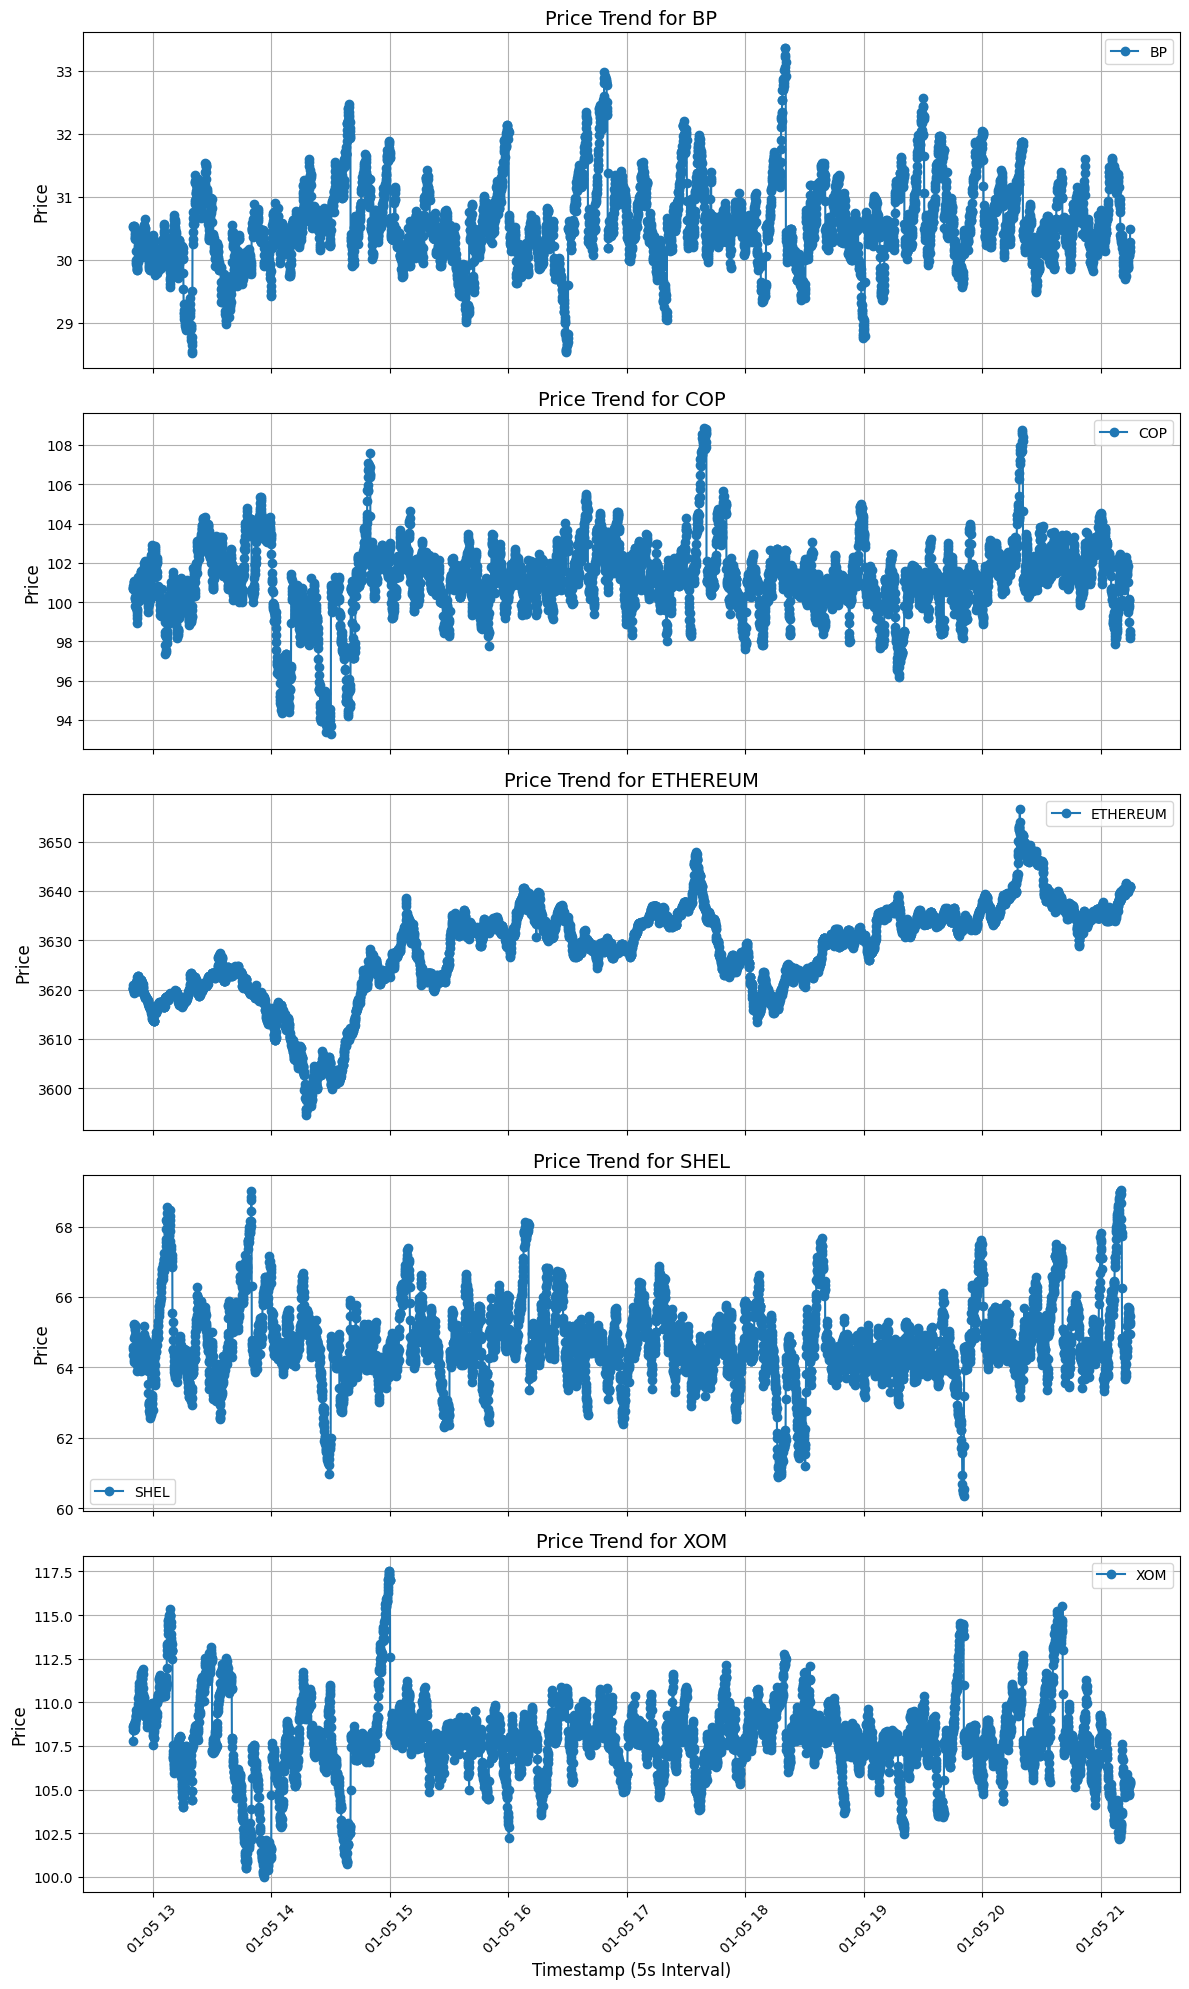

In [30]:
# Create subplots for each symbol
symbols = merged_df.index.unique()  # Retrieve unique symbols from the index
num_symbols = len(symbols)

fig, axes = plt.subplots(num_symbols, 1, figsize=(12, 4 * num_symbols), sharex=True)

# Plot each symbol on a separate axis
for ax, symbol in zip(axes, symbols):
    symbol_data = merged_df.loc[symbol]
    ax.plot(symbol_data['5s_interval'], symbol_data['price'], label=symbol, marker='o')
    ax.set_title(f"Price Trend for {symbol}", fontsize=14)
    ax.set_ylabel("Price", fontsize=12)
    ax.grid(True)
    ax.legend()

# Customize the shared x-axis
axes[-1].set_xlabel("Timestamp (5s Interval)", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()


In [31]:
trimmed_df

,5s_interval,bid,ask,spread_raw,spread_table,volume,volatility,market_sentiment,trading_activity,price
symbol,,,,,,,,,,
BP,2025-01-05 12:50:15,NaN,NaN,NaN,NaN,6.456771e+06,0.694000,0.4240,39.520000,30.540000
COP,2025-01-05 12:50:15,NaN,NaN,NaN,NaN,3.425032e+06,1.486222,0.1290,29.926667,100.728889
ETHEREUM,2025-01-05 12:50:15,3613.833333,3626.533333,12.700,12.700,NaN,NaN,NaN,NaN,3620.183333
SHEL,2025-01-05 12:50:15,NaN,NaN,NaN,NaN,4.827323e+06,0.390000,-0.3160,58.850000,64.590000
XOM,2025-01-05 12:50:15,NaN,NaN,NaN,NaN,1.351476e+07,0.397000,-0.0740,60.940000,108.640000
...,...,...,...,...,...,...,...,...,...,...
BP,2025-01-05 21:14:50,NaN,NaN,NaN,NaN,4.532414e+06,0.432000,-0.4935,55.985000,30.485000
COP,2025-01-05 21:14:50,NaN,NaN,NaN,NaN,3.012491e+06,1.488000,-0.8700,18.490000,98.150000
ETHEREUM,2025-01-05 21:14:50,3633.960000,3647.525000,13.565,13.565,NaN,NaN,NaN,NaN,3640.742500


In [60]:
df = trimmed_df.copy()
# Convert '5s_interval' to a datetime type
df['5s_interval'] = pd.to_datetime(df['5s_interval'])

# Sort by symbol and timestamp
df = df.sort_values(by=['symbol', '5s_interval'])

# Create the 1-minute-ahead price (12 rows ahead for 5-second intervals)
df['price_1min_ahead'] = df.groupby('symbol')['price'].shift(-12)

# Drop rows where the target variable (price_1min_ahead) is NaN
df = df.dropna(subset=['price_1min_ahead'])

df

,index,symbol,5s_interval,bid,ask,spread_raw,spread_table,volume,volatility,market_sentiment,trading_activity,price,price_1min_ahead
0,0,BP,2025-01-05 12:50:15,NaN,NaN,NaN,NaN,6456771.0,0.69400,0.42400,39.5200,30.5400,30.330
5,5,BP,2025-01-05 12:50:20,NaN,NaN,NaN,NaN,6254577.0,0.68100,0.31950,40.4550,30.5150,30.390
10,10,BP,2025-01-05 12:50:25,NaN,NaN,NaN,NaN,6234542.0,0.68050,0.32625,38.5975,30.5175,30.365
15,15,BP,2025-01-05 12:50:30,NaN,NaN,NaN,NaN,6214507.0,0.68000,0.33300,36.7400,30.5200,30.340
20,20,BP,2025-01-05 12:50:35,NaN,NaN,NaN,NaN,6228992.0,0.68275,0.32675,37.0325,30.5250,30.140
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30199,30199,XOM,2025-01-05 21:13:30,NaN,NaN,NaN,NaN,13484144.0,0.68800,-0.47700,44.2400,105.8700,105.250
30204,30204,XOM,2025-01-05 21:13:35,NaN,NaN,NaN,NaN,13752168.0,0.68700,-0.48450,45.5350,105.6100,105.305
30209,30209,XOM,2025-01-05 21:13:40,NaN,NaN,NaN,NaN,14020192.0,0.68600,-0.49200,46.8300,105.3500,105.360
30214,30214,XOM,2025-01-05 21:13:45,NaN,NaN,NaN,NaN,14325591.0,0.67150,-0.54800,51.8400,104.9000,105.415


In [64]:
# merged_df

In [65]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
import time

In [66]:
# Initialize Spark session
spark = SparkSession.builder.appName("SymbolModelTraining").getOrCreate()

In [67]:
# Define symbols and their corresponding features
symbols_features = {
    "BP": ["volume", "volatility", "market_sentiment", "trading_activity", 
           "price"],
    "COP": ["volume", "volatility", "market_sentiment", "trading_activity", 
            "price"],
    "SHEL": ["volume", "volatility", "market_sentiment", "trading_activity", 
             "price"],
    "XOM": ["volume", "volatility", "market_sentiment", "trading_activity", 
            "price"],
    "ETHEREUM": ["bid", "ask", "spread_raw", "spread_table", 
                 "price"],
}
# Target column
target_col = "price_1min_ahead"

# Generate a timestamp for this training session
timestamp = time.strftime("%Y%m%d_%H%M%S")

In [68]:
df = df.reset_index()

df = spark.createDataFrame(df)

In [69]:
df

DataFrame[level_0: bigint, index: bigint, symbol: string, 5s_interval: timestamp, bid: double, ask: double, spread_raw: double, spread_table: double, volume: double, volatility: double, market_sentiment: double, trading_activity: double, price: double, price_1min_ahead: double]

In [70]:
df.printSchema()

root
 |-- level_0: long (nullable = true)
 |-- index: long (nullable = true)
 |-- symbol: string (nullable = true)
 |-- 5s_interval: timestamp (nullable = true)
 |-- bid: double (nullable = true)
 |-- ask: double (nullable = true)
 |-- spread_raw: double (nullable = true)
 |-- spread_table: double (nullable = true)
 |-- volume: double (nullable = true)
 |-- volatility: double (nullable = true)
 |-- market_sentiment: double (nullable = true)
 |-- trading_activity: double (nullable = true)
 |-- price: double (nullable = true)
 |-- price_1min_ahead: double (nullable = true)



In [71]:
df.show()

+-------+-----+------+-------------------+---+---+----------+------------+-----------------+------------------+-------------------+------------------+------------------+------------------+
|level_0|index|symbol|        5s_interval|bid|ask|spread_raw|spread_table|           volume|        volatility|   market_sentiment|  trading_activity|             price|  price_1min_ahead|
+-------+-----+------+-------------------+---+---+----------+------------+-----------------+------------------+-------------------+------------------+------------------+------------------+
|      0|    0|    BP|2025-01-05 12:50:15|NaN|NaN|       NaN|         NaN|        6456771.0|             0.694|              0.424|             39.52|             30.54|             30.33|
|      5|    5|    BP|2025-01-05 12:50:20|NaN|NaN|       NaN|         NaN|        6254577.0|             0.681|             0.3195|            40.455|            30.515|             30.39|
|     10|   10|    BP|2025-01-05 12:50:25|NaN|NaN|     

In [72]:
from pyspark.ml.pipeline import PipelineModel
import os

In [73]:
def load_latest_model(symbol, models_dir = './models'):
    """
    Load the latest model for a given symbol.
    """
    try:
        # List all directories in the models path
        model_dirs = [d for d in os.listdir(models_dir) if os.path.isdir(os.path.join(models_dir, d))]

        # Filter model directories for the given symbol
        symbol_model_dirs = [d for d in model_dirs if d.startswith(f"{symbol}_model_")]

        if not symbol_model_dirs:
            print(f"No models found for symbol: {symbol}")
            return None

        # Sort directories by timestamp (assuming the format: <symbol>_model_<timestamp>)
        latest_model_dir = sorted(symbol_model_dirs, key=lambda x: x.split('_')[-1])[-1]

        # Construct the full path to the latest model
        latest_model_path = os.path.join(models_dir, latest_model_dir)

        # Load the latest model
        print(f"Loading model from: {latest_model_path}")
        return PipelineModel.load(latest_model_path)

    except Exception as e:
        print(f"Error loading the latest model: {e}")
        return None

In [74]:
for symbol, features in symbols_features.items():
    print(f"Training model for symbol: {symbol}")
    
    # Filter data for the symbol
    symbol_df = df.filter(df["symbol"] == symbol)  # Ensure 'symbol' is a column
    
    # Drop rows with missing values
    symbol_df = symbol_df.dropna(subset=features + [target_col])
    
    # Check if 'features' already exists and drop it to avoid conflicts
    if "features" in symbol_df.columns:
        symbol_df = symbol_df.drop("features")
    
    # Assemble features into a single vector with a unique name
    feature_col_name = f"{symbol}_features"
    assembler = VectorAssembler(inputCols=features, outputCol=feature_col_name)
    symbol_df = assembler.transform(symbol_df)
    
    # # Split data into train, validation, and test sets
    # train_df, temp_df = symbol_df.randomSplit([0.7, 0.3], seed=42)
    # val_df, test_df = temp_df.randomSplit([0.5, 0.5], seed=42)
    
    # Train a Linear Regression model
    lr = LinearRegression(featuresCol=feature_col_name, labelCol=target_col, predictionCol="prediction")
    pipeline = Pipeline(stages=[lr])  # No need to reassemble in the pipeline
    model = pipeline.fit(symbol_df)
    
    # Evaluate on validation set
    evaluator = RegressionEvaluator(labelCol=target_col, predictionCol="prediction", metricName="rmse")
    val_predictions = model.transform(symbol_df)
    rmse = evaluator.evaluate(val_predictions)
    print(f"Symbol: {symbol}, Validation RMSE: {rmse}")
    
    
    # check if a model is already deployed
    old_model = load_latest_model(symbol)
    if old_model == None:
        pass
    else:
        # compare metrics
        old_val_predictions = old_model.transform(symbol_df)
        old_rmse = evaluator.evaluate(old_val_predictions)
        print(f"Old model RMSE: {old_rmse}")
        if rmse >= old_rmse:
            print("New model is worse. Keeping the old one.")
            continue
        else:
            print("New model is better. Saving it.")

    # Save the model with a timestamp
    model_path = f"models/{symbol}_model_{timestamp}"
    model.save(model_path)
    print(f"Model for {symbol} saved at {model_path}")


Training model for symbol: BP


25/01/05 21:20:38 WARN Instrumentation: [862ec280] regParam is zero, which might cause numerical instability and overfitting.


Symbol: BP, Validation RMSE: 0.43422509271502163
No models found for symbol: BP


Model for BP saved at models/BP_model_20250105_211957
Training model for symbol: COP


25/01/05 21:20:55 WARN Instrumentation: [975baec6] regParam is zero, which might cause numerical instability and overfitting.


Symbol: COP, Validation RMSE: 1.2955190438955135
No models found for symbol: COP
Model for COP saved at models/COP_model_20250105_211957
Training model for symbol: SHEL


25/01/05 21:21:05 WARN Instrumentation: [a3c3a5fc] regParam is zero, which might cause numerical instability and overfitting.


Symbol: SHEL, Validation RMSE: 0.7809209173197501
No models found for symbol: SHEL
Model for SHEL saved at models/SHEL_model_20250105_211957
Training model for symbol: XOM


25/01/05 21:21:13 WARN Instrumentation: [6e43e938] regParam is zero, which might cause numerical instability and overfitting.


Symbol: XOM, Validation RMSE: 1.4516919327432125
No models found for symbol: XOM


Model for XOM saved at models/XOM_model_20250105_211957
Training model for symbol: ETHEREUM


25/01/05 21:21:20 WARN Instrumentation: [514df1be] regParam is zero, which might cause numerical instability and overfitting.
25/01/05 21:21:21 WARN Instrumentation: [514df1be] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


Symbol: ETHEREUM, Validation RMSE: 1.7332622753947935
No models found for symbol: ETHEREUM
Model for ETHEREUM saved at models/ETHEREUM_model_20250105_211957


In [75]:
from pyspark.sql import functions as F
from datetime import datetime

ms_timestamp = messages[current_value-1]['timestamp']

In [76]:
datetime_str = datetime.fromtimestamp(ms_timestamp / 1000).strftime('%Y-%m-%d %H:%M:%S')

# Convert '5s_interval' to timestamp if not already
symbol_df = symbol_df.withColumn("5s_interval", F.col("5s_interval").cast("timestamp"))

# Filter rows where '5s_interval' is greater than the datetime
test_df = symbol_df.filter(F.col("5s_interval") > F.lit(datetime_str))

# Show the filtered DataFrame
test_df.show()

+-------+-----+--------+-------------------+------------------+------------------+------------------+------------------+------+----------+----------------+----------------+------------------+------------------+--------------------+
|level_0|index|  symbol|        5s_interval|               bid|               ask|        spread_raw|      spread_table|volume|volatility|market_sentiment|trading_activity|             price|  price_1min_ahead|   ETHEREUM_features|
+-------+-----+--------+-------------------+------------------+------------------+------------------+------------------+------+----------+----------------+----------------+------------------+------------------+--------------------+
|  20002|20002|ETHEREUM|2025-01-05 18:23:35|          3616.115|3629.3900000000003|            13.275|            13.275|   NaN|       NaN|             NaN|             NaN|         3622.7525|3622.7749999999996|[3616.115,3629.39...|
|  20007|20007|ETHEREUM|2025-01-05 18:23:40|3616.0074999999997|3629.2825